In [40]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sci
from statsmodels.regression.linear_model import OLS


pd.set_option('float_format', '{:6.5f}'.format)
sns.set(style='ticks')

import warnings
warnings.filterwarnings("ignore")


CPU times: user 1.37 ms, sys: 163 µs, total: 1.53 ms
Wall time: 1.48 ms


In [4]:
df=pd.read_csv('wifi.txt',sep='\t')

In [5]:
df.head()

,AP1,AP2,AP3,AP4,AP5,AP6,AP7,Room
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1


In [6]:
X = df[['AP1','AP2','AP3','AP4','AP5','AP6','AP7']]
y = df['Room']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify = y)

In [121]:
#2

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text

error_tree = pd.DataFrame(columns = ['T','error_is','error_oos'])
best_test_error = None 
best_max_leaf = None

for i in range(2,51):
    dt = DecisionTreeClassifier(random_state=None, max_leaf_nodes=i)
    dt = dt.fit(X_train, y_train)
    error_tree = error_tree.append({'T':i, 'error_is': 1 - dt.score(X_train,y_train),
                                   'error_oos': 1 - dt.score(X_test,y_test)},ignore_index = True)
    
    if best_test_error is None:                          # to find the best t where the test error is minimal
        best_test_error = 1 - dt.score(X_test,y_test)
    elif best_test_error > 1 - dt.score(X_test,y_test):
        best_test_error = 1 - dt.score(X_test,y_test)
        best_max_leaf = i

print('best_test_error:',best_test_error,'best_max_leaf:',best_max_leaf)

best_test_error: 0.02400000000000002 best_max_leaf: 38


In [122]:

dt = DecisionTreeClassifier(random_state=None, max_leaf_nodes = best_max_leaf)
dt = dt.fit(X_train, y_train)
tx = export_text(dt, feature_names=['AP1','AP2','AP3','AP4','AP5','AP6','AP7'])

print(tx)

|--- AP1 <= -54.50
|   |--- AP5 <= -59.50
|   |   |--- AP4 <= -55.50
|   |   |   |--- AP3 <= -50.50
|   |   |   |   |--- AP5 <= -61.50
|   |   |   |   |   |--- AP3 <= -52.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- AP3 >  -52.00
|   |   |   |   |   |   |--- AP7 <= -87.50
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- AP7 >  -87.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- AP5 >  -61.50
|   |   |   |   |   |--- AP6 <= -82.00
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- AP6 >  -82.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- AP3 >  -50.50
|   |   |   |   |--- AP2 <= -53.00
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- AP2 >  -53.00
|   |   |   |   |   |--- class: 1
|   |   |--- AP4 >  -55.50
|   |   |   |--- AP2 <= -50.50
|   |   |   |   |--- class: 3
|   |   |   |--- AP2 >  -50.50
|   |   |   |   |--- class: 1
|   |--- AP5 >  -59.50
|   |   |--- AP5 <= -56.50
|   |   |   |--- AP7 <

In [123]:
# for the test sample
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true = y_test, y_pred = dt.predict(X_test), labels = [1,2,3,4]) # confusion matrix

array([[[373,   2],
        [  0, 125]],

       [[370,   5],
        [  6, 119]],

       [[368,   7],
        [  8, 117]],

       [[373,   2],
        [  2, 123]]])

In [124]:
# for the train sample
multilabel_confusion_matrix(y_true = y_train, y_pred = dt.predict(X_train), labels = [1,2,3,4])

array([[[1125,    0],
        [   0,  375]],

       [[1125,    0],
        [   2,  373]],

       [[1123,    2],
        [   0,  375]],

       [[1125,    0],
        [   0,  375]]])

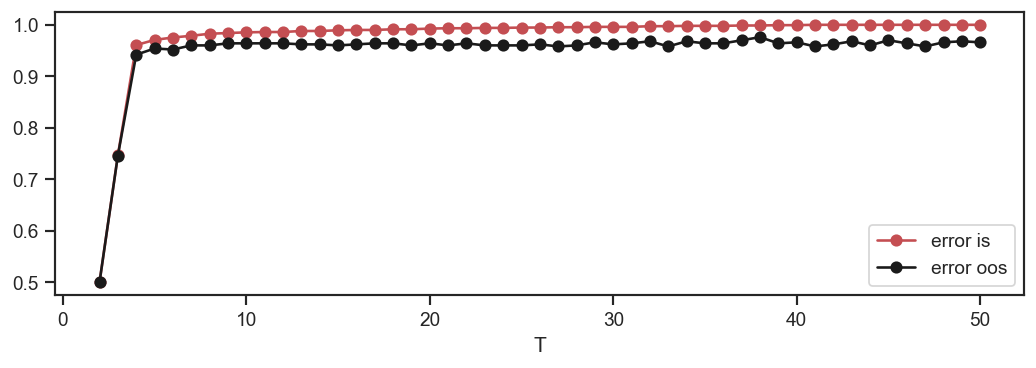

In [125]:
plt.figure(figsize = (10,3), dpi = 125)
plt.plot(error_tree['T'],1 - error_tree.error_is,'ro-', label = 'error is')
plt.plot(error_tree['T'],1 - error_tree.error_oos, 'ko-', label = 'error oos')
plt.xlabel('T')
plt.legend();

Trees can be overfitting if the number of leaf nodes is quite large relative to observations, because this method separates the area until each observation is inside of the own square. In our example, we might look at the plot and after the particular T (the number of the leafs) point the accuracy becomes equal to 1 on the train sample. However, the test sample accuracy is not equal to 1, it is a bit smaller. This is overfitting.

In [133]:
#3
from sklearn.ensemble import BaggingClassifier

best_oos = None
best_t = None

for i in range(2,51):                                                  # in this cycle we use different length of the tree and try to find 
    bgg = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes = i), # the best one where the error is minimal
                        n_estimators = 1000,
                        max_samples = 1500,
                        bootstrap = True,
                        n_jobs=-1)
    bgg.fit(X_train,y_train)
    
    if best_oos is None:                                # to find the minimal error and the number of T
        best_oos = 1 - bgg.score(X_test,y_test)
    elif best_oos > 1 - bgg.score(X_test,y_test):
        best_oos = 1 - bgg.score(X_test,y_test)
        best_t = i

print('best_oos:',best_oos,'best_t:',best_t)

bgg = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes = best_t),
                        n_estimators = 1000,
                        max_samples = 1500,
                        bootstrap = True,
                        n_jobs=-1)
bgg.fit(X_train,y_train)
multilabel_confusion_matrix(y_true = y_test, y_pred = bgg.predict(X_test), labels = [1,2,3,4])  # confusion matrix fot the best model

best_oos: 0.02200000000000002 best_t: 35


array([[[374,   1],
        [  0, 125]],

       [[371,   4],
        [  6, 119]],

       [[368,   7],
        [  5, 120]],

       [[374,   1],
        [  2, 123]]])

Begging helps to reduce variance. We computed many trees and then aggregate them. The test error usually decreases relative to a single tree. The same result we see here the test error is a bit lower than in the previous example. 

In [130]:
#4
from sklearn.ensemble import RandomForestClassifier 
random_forest = pd.DataFrame(columns = ['t','m','test_error'])
best_t = None
best_m = None
best_test_error = None

for t in range(2,51):
    for m in range(1,7):                                # here we use 2 cycles because we have to use two parametres the tree length 
                                                        # and the number of the features in each step for constructing the tree
        rf = RandomForestClassifier(n_estimators=1000,     
                                    max_samples = 1500,
                                    max_leaf_nodes= t,
                                    max_features = m,
                                    n_jobs=-1)
        rf.fit(X_train,y_train)
        
        random_forest = random_forest.append({'t': t, 
                                              'm': m, 
                                              'test_error': 1 - rf.score(X_test,y_test)},
                                             ignore_index = True)         # here we find the best number for T and M (the number of the feat)
        if best_t is None:
            best_t = t
            best_m = m
            best_test_error = 1 - rf.score(X_test,y_test)
        elif best_test_error > 1 - rf.score(X_test,y_test):
            best_test_error = 1 - rf.score(X_test,y_test)
            best_t = t
            best_m = m
            
print('best t:', best_t,'best m:', best_m, 'best_test_error:',best_test_error)
        

best t: 32 best m: 3 best_test_error: 0.014000000000000012


In [132]:
rf = RandomForestClassifier(n_estimators=1000, 
                                    max_samples = 1500,
                                    max_leaf_nodes= best_t,
                                    max_features = best_m,
                                    bootstrap = True,
                                    oob_score = True,
                                    n_jobs=-1)
rf.fit(X_train,y_train)
multilabel_confusion_matrix(y_true = y_test, y_pred = rf.predict(X_test), labels = [1,2,3,4])

array([[[373,   2],
        [  0, 125]],

       [[375,   0],
        [  6, 119]],

       [[369,   6],
        [  2, 123]],

       [[374,   1],
        [  1, 124]]])

Begging has some drawback. Using the same features all the time then trees practically constructs in the same way, therefore, there is a high correlation between the trees. In random forest we use different features in each step, thus, we reduce the correlation and as a consequence it reduces the variance even. Due to this thing the model will be more robust. The test error is lower compared to the other methods.

In [45]:
#5
# OOB for 3, bagging 
oob_score = pd.DataFrame(columns = ['t','oob_score'])
best_oob = None
best_t = None

for t in range(2,51):
    bgg = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes = t),
                        n_estimators = 1000,
                        max_samples = 2000,
                        bootstrap = True,
                        oob_score=True,
                        n_jobs=-1)
    bgg.fit(X,y)
    
    oob_score = oob_score.append({'t':t,'oob_score':bgg.oob_score_}, ignore_index = True)
    
    if best_oob is None:                    # the best oob score relative to the length
        best_oob = 1 - bgg.oob_score_
    elif best_oob > 1 - bgg.oob_score_:
        best_oob = 1 - bgg.oob_score_
        best_t = t

print('best_oob:',best_oob,'best_t:',best_t)

best_oob: 0.01849999999999996 best_t: 42


UsageError: Line magic function `%%time` not found.


In [129]:
from sklearn.ensemble.forest import _generate_unsampled_indices

bgg = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes = 42),
                        n_estimators = 1000,
                        max_samples = 2000,
                        bootstrap = True,
                        oob_score=True,
                        n_jobs=-1)


bgg.fit(X,y)
print('error out of bag:', 1 - bgg.oob_score_)

for rand_state in bgg.estimators_:                #there are 1000 trees for constructing, therefore, 1000 different samples. Each sample has
    indices = _generate_unsampled_indices(        # random state, we try to get find this random state for the particular tree, thus,
    rand_state.random_state,X.shape[0],1000)      # we get all observations that are used in this tree => to get oob we take the opposite ones
    
multilabel_confusion_matrix(y_true = np.array(y.iloc[indices]), 
                            y_pred = np.array(bgg.predict(X.iloc[indices])), # for that oob observations we predict and calculate the matrix
                            labels = [1,2,3,4])

error out of bag: 0.020000000000000018


array([[[936,   0],
        [  0, 290]],

       [[907,   0],
        [  0, 319]],

       [[920,   0],
        [  0, 306]],

       [[915,   0],
        [  0, 311]]])

In [117]:
# OOB for 4, random forest 

oob_randomforest = pd.DataFrame(columns = ['t','m','oob_score'])
best_t = None
best_m = None
best_test_error = None

for t in range(2,51):
    for m in range(1,7):

        rf = RandomForestClassifier(n_estimators=1000, 
                                    max_samples = 2000,
                                    max_leaf_nodes= t,
                                    max_features = m,
                                    oob_score = True,
                                    n_jobs=-1)
        rf.fit(X,y)
        
        oob_randomforest = oob_randomforest.append({'t': t, 
                                              'm': m, 
                                              'oob_score': 1 - rf.oob_score_},
                                             ignore_index = True)
        if best_t is None:
            best_t = t
            best_m = m
            best_test_error = 1 - rf.oob_score_
        elif best_test_error > 1 - rf.oob_score_:
            best_test_error = 1 - rf.oob_score_
            best_t = t
            best_m = m
            
print('best t:', best_t,'best m:', best_m, 'best_test_error:',best_test_error)


best t: 44 best m: 1 best_test_error: 0.014499999999999957


In [118]:
rf = RandomForestClassifier(n_estimators=1000, 
                                    max_samples = 2000,
                                    max_leaf_nodes= best_t,
                                    max_features = best_m,
                                    oob_score = True,
                                    n_jobs=-1)
rf.fit(X,y)

for rand_state in rf.estimators_:
    indices = _generate_unsampled_indices(
    rand_state.random_state,X.shape[0],1000)
    
multilabel_confusion_matrix(y_true = np.array(y.iloc[indices]), 
                            y_pred = np.array(rf.predict(X.iloc[indices])), 
                            labels = [1,2,3,4])

array([[[907,   1],
        [  1, 309]],

       [[906,   1],
        [  4, 307]],

       [[923,   5],
        [  2, 288]],

       [[910,   1],
        [  1, 306]]])

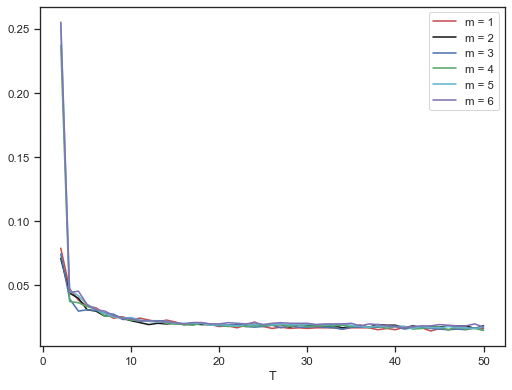

In [119]:
plt.figure(figsize = (8,6), dpi = 75)                             # here I plot the oob errors for different M.
plt.plot(oob_randomforest[oob_randomforest['m'] == 1].t,
         oob_randomforest[oob_randomforest['m'] == 1].oob_score,
         'r-', 
         label = 'm = 1')
plt.plot(oob_randomforest[oob_randomforest['m'] == 2].t,
         oob_randomforest[oob_randomforest['m'] == 2].oob_score,
         'k-', 
         label = 'm = 2')
plt.plot(oob_randomforest[oob_randomforest['m'] == 3].t,
         oob_randomforest[oob_randomforest['m'] == 3].oob_score,
         'b-', 
         label = 'm = 3')
plt.plot(oob_randomforest[oob_randomforest['m'] == 4].t,
         oob_randomforest[oob_randomforest['m'] == 4].oob_score,
         'g-', 
         label = 'm = 4')
plt.plot(oob_randomforest[oob_randomforest['m'] == 5].t,
         oob_randomforest[oob_randomforest['m'] == 5].oob_score,
         'c-', 
         label = 'm = 5')
plt.plot(oob_randomforest[oob_randomforest['m'] == 6].t,
         oob_randomforest[oob_randomforest['m'] == 6].oob_score,
         'm-', 
         label = 'm = 6')
plt.legend('best')

plt.xlabel('T')
plt.legend();

In my opinion, this way of testing models is better compared to the previous one. OOB observations are unsampled observations in each tree construction. That is why we might use all observations from the entire sample data, thereby increasing the number of observations on which we fit the model. As a result, the number of oob observations can be more than half of the train data. if we separated test and train data in such proportion, we would use not so much observation for fitting the model, which is not good.